# MNIST with augmentation classification

## Table of contents

1. [Task description](#Task-description)   
2. [Dataset](#Dataset)   
3. [Model archtecture](#Model-architecture)   
4. [Training](#Training)   
5. [Model validation](#Model-validation)   
6. [Summary](#Summary)   
7. [What can be improved?](#What-can-be-improved?)

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Task description

Given the image of hanrdwritten digit we apply resizing, scaling, rotating, adding the noise operations to the 28x28 pixels image to make it harder to recognise. Then we try to classify it.

## Dataset

We will be using _[MNIST](http://yann.lecun.com/exdb/mnist/)_ dataset for training as well as for model validation.   
MNIST dataset consists of handwritten digits, it has training set of 60 000  examples and testing set of 10 000 examples.   
Images size is 28x28 pixels in greyscale, besides there is array of true labels for each image in the dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from batchflow.opensets import MNIST
from torch.nn import CrossEntropyLoss
from sklearn.utils.extmath import softmax
from batchflow.models.torch import ResNet18
from batchflow import dataset, B, V, R, P, Pipeline

from batch import MyBatch
from utils import show_digits, plot_bar

Download data using build-in batchflow [functions](https://analysiscenter.github.io/batchflow/api/batchflow.opensets.html)

In [ ]:
dataset = MNIST(batch_class=MyBatch)

Originally MNIST consists of size-normalized and centred images. However, in practise handwritten text can be rotated, scaled, contain some random strokes e.t.c. Lets get closer to this curcumstances and spoil our dataset. We add some prebuilded actions from [ImagesBatch](https://analysiscenter.github.io/batchflow/intro/images_batch.html)  as well as add custom ones.

In [4]:
augmentation = (Pipeline()
                .resize((64,64))
                .rotate(angle=P(R('uniform', -35, 35)))
                .scale(factor=P(R('uniform', 0.5, 1.5)), 
                       preserve_shape=True, origin='random')
                .to_rgb()
                .invert(channels=P(R('randint', 0, 3)), p=0.5)
                .custom_noise()
                .preprocess_labels()
                .preprocess_images())

Take a look what images we finally got.

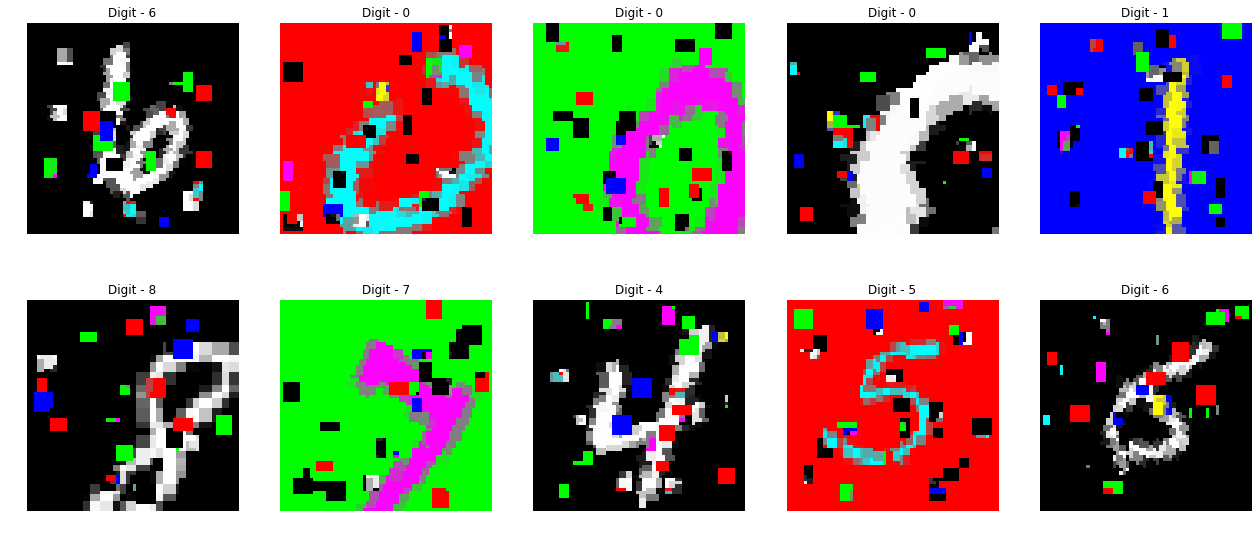

In [5]:
augm = augmentation << dataset.test
batch = augm.next_batch(10, shuffle=True)
show_digits(batch)

## Model architecture

For this task we will try using ready-to-use ResNet18 model from [Torch models Zoo](https://analysiscenter.github.io/batchflow/intro/model_zoo_torch.html)

We specify the loss function and the input shape

In [6]:
config = {
    'inputs': dict(images={'shape': (3, 64, 64)},
                  labels={'classes': 10,
                         'transform': 'ohe'}),
    'initial_block/inputs': 'images',
    'loss': CrossEntropyLoss,
    'optimiser': 'Adam',
    'device': 'cuda:0'
}

## Training

Define training pipeline.

In [7]:
train_pipeline = (augmentation 
         + Pipeline()
             .init_model('dynamic', ResNet18, 'my_model', config)
             .init_variable('loss', init_on_each_run=list)
             .train_model('my_model', B('images'), B('labels'),
                          fetches='loss', save_to=V('loss'), mode='a')
        ) << dataset.train

Training the model for 2 epochs using batch size 64.

In [8]:
train_pipeline.run(64, shuffle=True, n_epochs=2, bar=True)

100%|█████████▉| 1874/1875 [05:05<00:00,  6.27it/s]


## Model validation

Lets run test pipeline

In [16]:
test_pipeline = (augmentation
        + Pipeline()
            .import_model('my_model', train_pipeline)
            .init_variable('metrics', init_on_each_run=list)
            .init_variable('predictions', init_on_each_run=list)
            .predict_model('my_model', B('images'), B('labels'),
                           fetches='predictions', save_to=V('predictions'))
            .gather_metrics('class', targets=B('labels'), fmt='logits',
                            axis=1, predictions=V('predictions'),
                            num_classes=10,  save_to=V('metrics'), mode='a')
       ) << dataset.test

In [17]:
test_pipeline.run(64, n_epochs=1, bar=True)

 99%|█████████▉| 156/157 [00:19<00:00,  7.78it/s]


Check the accuracy of the model on test data.

In [34]:
metrics = test_pipeline.get_variable('metrics')
acc = sum(m.evaluate('accuracy') for m in metrics) / len(metrics)
print('Accuracy of the model on test data - {:.2%}'.format(acc))

Accuracy of the model on test data - 84.83%


Lets see at model predictions

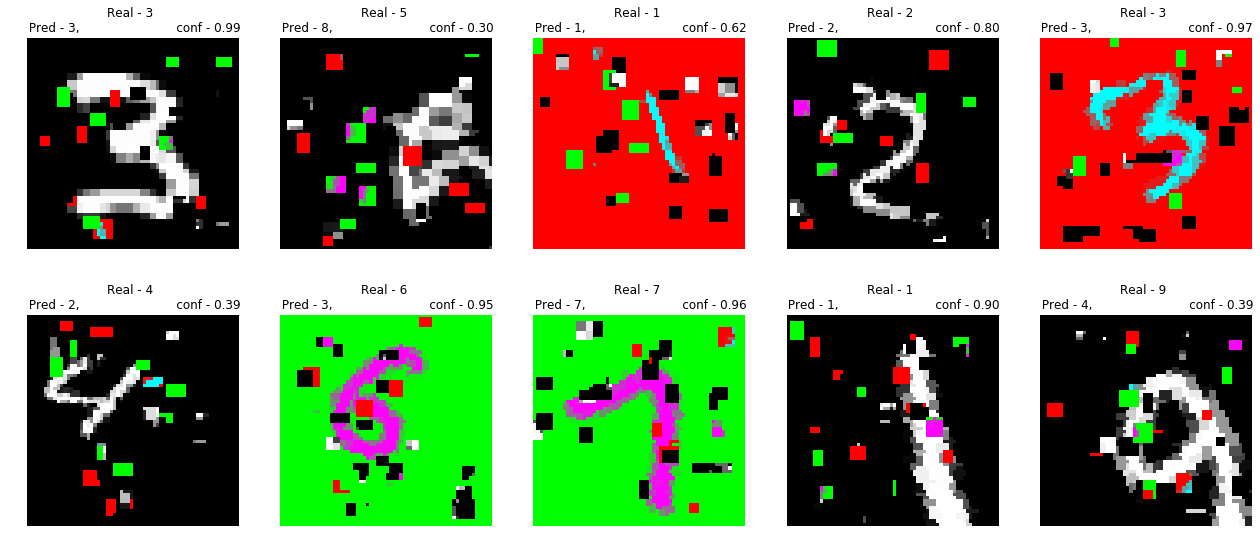

In [37]:
batch = test_pipeline.next_batch(10, shuffle=True)
pred = test_pipeline.get_variable('predictions')
show_digits(batch, pred)

Take a closer look to the digits  which confuses model the most. There are the most false positives in the class 7, since the model messing it with 1.

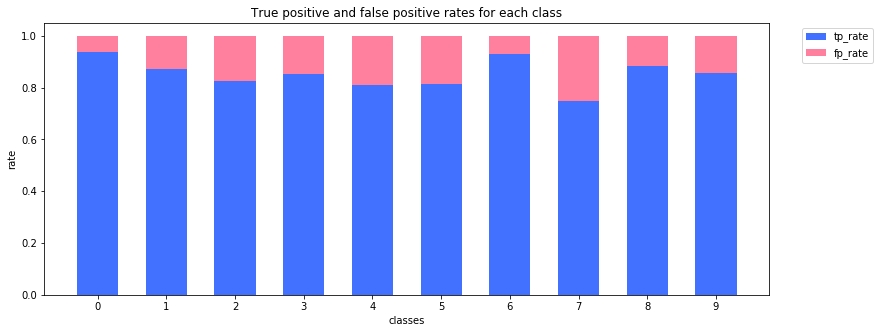

In [56]:
from utils import plot_bar
plot_bar(metrics)

## Summary

In this notebook we trained ResNet18 model on the MNIST dataset with augmentation. It can be seen that unlike original data where the model predicts almost without mistakes, as we adding some noise to the data the model accuracy reduces significantly

## What can be improved?

For futher investigation you can :
1. Use another augmentation actions
2. Vary the amount of noise on the image and check how changes accuracy.
3. Use more complicated datasets for augmnetation, like CIFAR